# Quantum Support Vector Machine Implementation Tutorial

In [6]:
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 12345

In [7]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

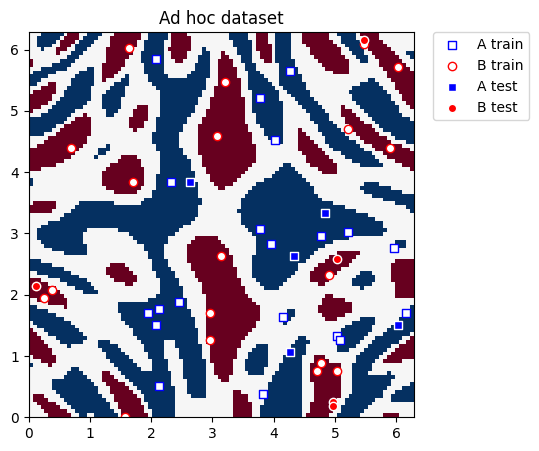

In [9]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### Defining the quantum kernel

In [10]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

### Classification with SVC

In [11]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


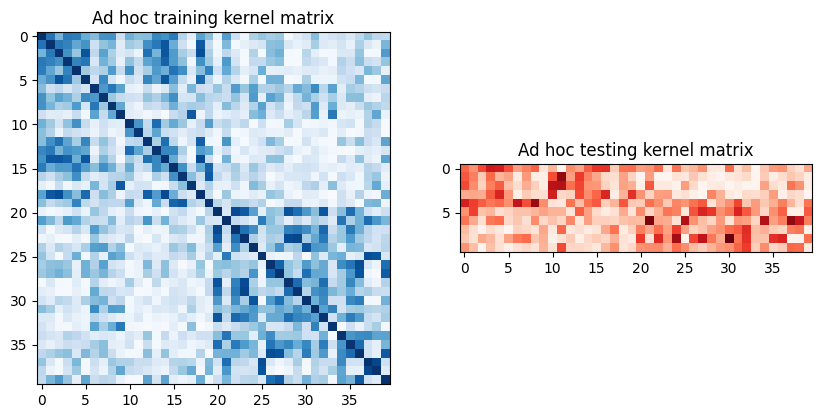

In [12]:
### Precomputed Kernel Matrix ###

adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [13]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### Classification with QSVC

In [14]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


In [15]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00
